In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

#from utils import confusion_matrix



In [5]:
csv_filename = '/content/drive/MyDrive/motionProject/2023-02-13_6axis_data.csv'
df = pd.read_csv(csv_filename, encoding='utf8', low_memory=False) # utf8, cp949 |
df.shape


(2631, 8)

In [6]:
df

,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
0,1,LeftRight,2.8379,2.9480,8.7386,42.5609,32.2639,105.0292
1,1,LeftRight,2.8283,2.5077,9.0018,22.6534,107.0886,177.1081
2,1,LeftRight,2.8283,2.5603,9.6335,48.0526,126.3097,179.8540
3,1,LeftRight,2.9001,2.8235,9.9254,131.1149,115.3262,182.5998
4,1,LeftRight,3.0389,4.1539,9.6861,194.2697,155.1412,222.4148
...,...,...,...,...,...,...,...,...
2626,50,LeftRight,1.8664,10.6672,12.4379,42.5609,413.9387,-204.5667
2627,50,LeftRight,1.5266,4.5224,14.2182,78.2571,-213.4908,-372.0643
2628,50,LeftRight,1.8712,6.3745,9.4851,-2.7459,-218.2960,-210.0584
2629,50,LeftRight,2.2971,4.8191,9.9206,-135.2337,-43.9338,-5.4917


In [7]:
display(df.head())

display(df.tail())

,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
0,1,LeftRight,2.8379,2.9480,8.7386,42.5609,32.2639,105.0292
1,1,LeftRight,2.8283,2.5077,9.0018,22.6534,107.0886,177.1081
2,1,LeftRight,2.8283,2.5603,9.6335,48.0526,126.3097,179.8540
3,1,LeftRight,2.9001,2.8235,9.9254,131.1149,115.3262,182.5998
4,1,LeftRight,3.0389,4.1539,9.6861,194.2697,155.1412,222.4148


,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
2626,50,LeftRight,1.8664,10.6672,12.4379,42.5609,413.9387,-204.5667
2627,50,LeftRight,1.5266,4.5224,14.2182,78.2571,-213.4908,-372.0643
2628,50,LeftRight,1.8712,6.3745,9.4851,-2.7459,-218.2960,-210.0584
2629,50,LeftRight,2.2971,4.8191,9.9206,-135.2337,-43.9338,-5.4917
2630,50,LeftRight,2.6369,3.2112,10.2796,32.2639,-186.7186,21.9669


In [8]:
train = df[['accX','accY','accZ','gyroX','gyroY','gyroZ']]

In [9]:
test = df['label']

In [10]:
test.unique()

array(['LeftRight', 'UpDown', 'MotionProject'], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.33, random_state=42)
# train-test data split
# X는 input, Y는 (정답)output

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1762, 6), (869, 6), (1762,), (869,))

In [13]:
epochs = 10
batch_size = 16
n_hidden = 32

In [14]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# To reshape the data, you need to convert the DataFrames to NumPy arrays first and then perform the reshape operation.

X_train = X_train.values
X_test = X_test.values

In [16]:
X_train

array([[ 3.1107000e+00,  2.5651000e+00,  7.9585000e+00,  2.5948390e+02,
        -3.1234180e+02,  2.8831550e+02],
       [ 3.9240000e-01,  2.4410000e-01,  1.0442300e+01, -1.0297000e+01,
        -1.6475200e+01, -1.7161640e+02],
       [-3.9434000e+00, -1.2447500e+01,  9.1071000e+00,  4.7366100e+01,
        -1.6337880e+02,  2.3820350e+02],
       ...,
       [-2.0291000e+00,  5.9820000e-01,  8.9539000e+00,  4.0432820e+02,
        -1.7504870e+02, -2.2948542e+03],
       [-1.1830100e+01, -7.0540000e+00,  1.6898100e+01, -2.1493235e+03,
         2.9140461e+03,  2.5193280e+02],
       [-2.0100000e+00,  1.0815600e+01,  8.1212000e+00, -1.0091040e+02,
         1.9221030e+02,  1.1923905e+03]])

In [17]:
y_train = y_train.values
y_test = y_test.values

In [18]:
# reshape input to be 3D [samples, timesteps, features]
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [19]:
X_train.shape

(1762, 1, 6)

In [20]:
X_test.shape

(869, 1, 6)

In [21]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1762, 1, 6) (1762,) (869, 1, 6) (869,)


In [22]:
# 분류하고 싶은 클래스 개수
n_classes = _count_classes(y_train) 
n_classes

3

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# ['PC' 'TABLET' 'MOBILE'] ==> [1 2 0]

In [24]:
y_test

array([0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1,
       2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0,
       2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1,
       0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1,
       0, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0,
       2, 0, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2, 2, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2,

In [25]:
from keras.utils import to_categorical

# 원 핫 인코딩 
#    0 1 2
# 1  0 1 0
# 2  0 0 1
# 0  1 0 0

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [26]:
model = Sequential()

# n_hidden : 은닉계층에 임베딩되는 차원
# LSTM cell =  n_hidden 차원으로 만드는 것
# timestep : split해서 넣을 데이터 절편 크기
# X_train = (1762, 1, 6)
model.add(LSTM(n_hidden, input_shape=(X_train.shape[1], X_train.shape[2])))
# input차원 - (timesteps, input_dim)

model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# loss : predicted 결과와 real 결과의 차이
# optimizer : local optimum에 빠지지 않도록 넘어가게 해주는 장치, Adam 많이 씀
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate
# print(confusion_matrix(Y_test, model.predict(X_test)))

Epoch 1/10
111/111 [==============================] - 4s 9ms/step - loss: 1.1718 - accuracy: 0.4030 - val_loss: 0.9070 - val_accuracy: 0.5098
Epoch 2/10
111/111 [==============================] - 0s 4ms/step - loss: 0.9128 - accuracy: 0.5573 - val_loss: 0.7629 - val_accuracy: 0.7307
Epoch 3/10
111/111 [==============================] - 0s 3ms/step - loss: 0.7835 - accuracy: 0.6776 - val_loss: 0.6946 - val_accuracy: 0.7491
Epoch 4/10
111/111 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.7049 - val_loss: 0.6463 - val_accuracy: 0.7514
Epoch 5/10
111/111 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.7389 - val_loss: 0.6305 - val_accuracy: 0.7572
Epoch 6/10
111/111 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.7537 - val_loss: 0.6063 - val_accuracy: 0.7733
Epoch 7/10
111/111 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.7633 - val_loss: 0.5974 - val_accuracy: 0.7745
Epoch 

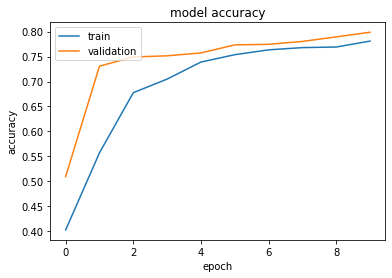

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test_classes, y_pred_classes))

28/28 [==============================] - 0s 1ms/step
[[403   0  43]
 [  7   0  45]
 [ 80   0 291]]


### 랜덤 인풋에 따른 예측결과

In [ ]:
test_data1 = np.array([2.8379, 2.9480, 8.7386, 42.5609, 32.2639, 105.0292])

In [ ]:
test_data1.shape

(6,)

In [ ]:
test_data1 = np.reshape(test_data1, (1, 1, len(test_data1)))

In [ ]:
test_data1.shape

(1, 1, 6)

In [ ]:
label = test.unique()
label

array(['LeftRight', 'UpDown', 'MotionProject'], dtype=object)

In [ ]:
np_class = np.argmax(model.predict(test_data1), axis=1)
np_class

1/1 [==============================] - 0s 71ms/step


array([0])

In [ ]:
label[np_class[0]]

'LeftRight'

In [29]:
test_data2 = np.array([0.9763, 0.7992, -0.938, -55.6037, 964.484, 582.1227])
test_data2 = np.reshape(test_data2, (1, 1, len(test_data2)))
label = test.unique()
np_class = np.argmax(model.predict(test_data2), axis=1)
label[np_class[0]]

1/1 [==============================] - 0s 26ms/step


'MotionProject'